In [1]:
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from math import *
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#load the tsv files of the features and respective responses
df=pd.read_csv('MP_Data.tsv', sep='\t', index_col=False)
tt_df=df.rename(columns={'x':'test_train'})
#tt_df

In [3]:
x_df=pd.read_csv('MP_Descriptors.tsv', sep='\t', index_col=False)
#x_df

In [4]:
y_df_init=pd.read_csv('MP_Outcome.tsv', sep='\t')
y_df=y_df_init.rename(columns={'x':'outcome'})
y_df.head()

,outcome
0,14.0
1,20.5
2,27.5
3,30.5
4,31.0


In [5]:
#sort the data according to exteranl and principal datasets sets
x_dataset_init_df=x_df[tt_df['test_train']=='Train']
x_external_init_df=x_df[tt_df['test_train']=='Test']

y_dataset_init_df=y_df[tt_df['test_train']=='Train']
y_external_init_df=y_df[tt_df['test_train']=='Test']

In [6]:
x_dataset_init_df.shape, y_dataset_init_df.shape, x_external_init_df.shape, y_external_init_df.shape

((4126, 202), (4126, 1), (275, 202), (275, 1))

In [7]:
x_dataset_init_df.head()

,diameter,petitjean,petitjeanSC,radius,VDistEq,VDistMa,weinerPath,weinerPol,a_aro,a_count,...,FASA_P,FCASA.,FCASA..1,VSA,dens,glob,std_dim1,std_dim2,std_dim3,vol
0,5,0.400000,0.666667,3,2.037476,6.011166,82,9,6,15,...,0.129128,0.326050,0.224950,138.13699,0.958985,0.031032,1.853123,1.382682,0.326444,123.18750
1,9,0.444444,0.800000,5,2.954872,8.805204,1046,40,11,31,...,0.059026,0.847237,1.136764,296.30197,1.296254,0.258447,2.394159,1.966377,1.217135,262.82812
2,10,0.500000,1.000000,5,3.083532,8.211762,742,24,12,35,...,0.046707,0.817581,0.464419,296.54431,0.946322,0.162139,3.164745,1.552043,1.274330,266.62500
3,7,0.428571,0.750000,4,2.616827,7.313269,288,20,10,20,...,0.044688,0.417896,0.574827,187.43799,1.195242,0.018573,2.524826,1.446899,0.344087,164.95312
4,7,0.428571,0.750000,4,2.609669,6.833154,203,13,6,22,...,0.103925,0.595412,0.267278,193.42802,0.978233,0.088156,2.550456,1.430062,0.757260,165.79688


In [8]:
x_dataset_df=np.array(x_dataset_init_df)
x_external_df=np.array(x_external_init_df)
x_dataset_df.shape, x_external_df.shape

((4126, 202), (275, 202))

In [9]:
y_dataset_df=np.array(y_dataset_init_df)
y_external_df=np.array(y_external_init_df)

In [10]:
#normalize the output
y_scaler=StandardScaler()
y_scaler.fit(y_dataset_df)
y_train_norm=y_scaler.transform(y_dataset_df)
y_external_norm=y_scaler.transform(y_external_df)

In [11]:
#normalize the inputs
x_scaler=StandardScaler()
x_scaler.fit(x_dataset_df)
x_train_pca=x_scaler.transform(x_dataset_df)
x_external_pca=x_scaler.transform(x_external_df)

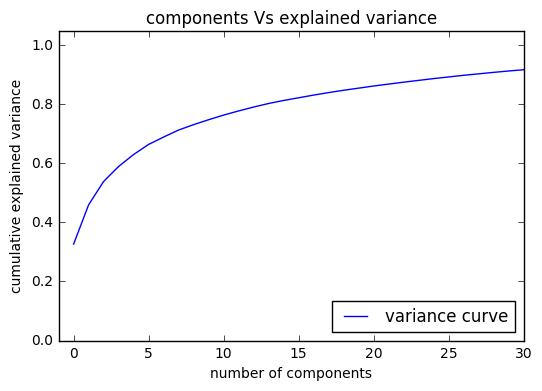

In [12]:
#feature selection
pca=PCA().fit(x_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='variance curve')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.xlim([-1, 30])
plt.title('components Vs explained variance')
plt.show()

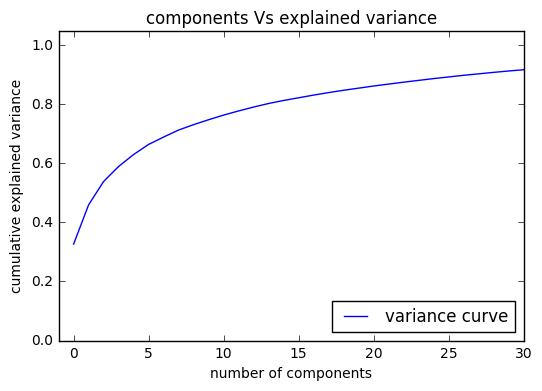

In [13]:
pca=PCA().fit(x_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='variance curve')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.xlim([-1, 30])
plt.title('components Vs explained variance')
plt.show()

In [14]:
pca=PCA(n_components=30)#from the literature
pca.fit(x_train_pca)
x_train_norm=pca.transform(x_train_pca)
x_external_norm=pca.transform(x_external_pca)

x_train_norm.shape, x_external_norm.shape

((4126, 30), (275, 30))

In [15]:
pc_1=x_train_norm[:, 1]
pc_2=x_train_norm[:, 2]
pc_ex_1 = x_external_norm[:,1]
pc_ex_2 = x_external_norm[:,2]

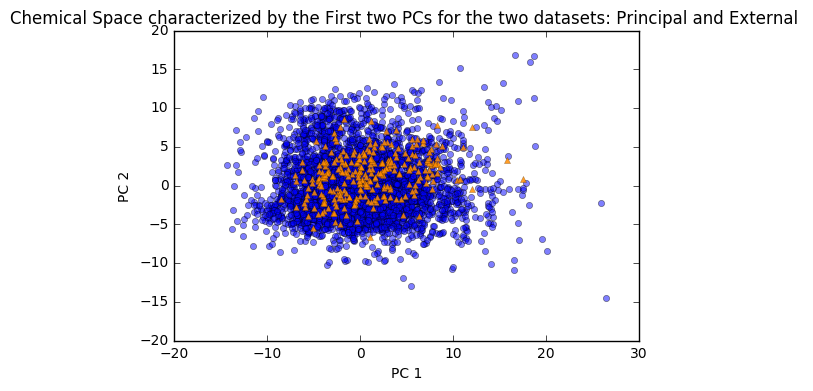

In [16]:
#Chemical space of the training and validation sets
for i in range(0, 4126):
    plt.scatter(pc_1[i], pc_2[i], c='b', alpha=0.5, marker='o', lw=0.5)
plt.hold(True)
for i in range(0, 275):    
    plt.scatter(pc_ex_1[i], pc_ex_2[i], c='darkorange', alpha=0.85, marker = '^', lw=0.15)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Chemical Space characterized by the First two PCs for the two datasets: Principal and External ')
#plt.legend(loc='lower right')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(x_train_norm, y_train_norm, test_size=0.2)
x_training_set.shape, x_test_set.shape, y_training_set.shape, y_test_set.shape

((3300, 30), (826, 30), (3300, 1), (826, 1))

In [18]:
#model building-linear regression
regr=linear_model.LinearRegression()
regr.fit(x_training_set, y_training_set)
y_predict_linear=regr.predict(x_test_set)

#evaluate the model

r2_linear=r2_score(y_test_set, y_predict_linear)
print('r2:',r2_linear)
mse_linear=mean_squared_error(y_test_set, y_predict_linear)
print('mse :',mse_linear)
rmse_linear=sqrt(mse_linear)
print('rmse:', rmse_linear)
mae_linear=mean_absolute_error(y_test_set, y_predict_linear)
print('mae:', mae_linear)

r2: 0.386076372185
mse : 0.609476814541
rmse: 0.7806899605739439
mae: 0.620337285061


In [19]:
#evaluate the model on the validation set
y_predict_linear_ex=regr.predict(x_external_norm)
r2_linear_ex=r2_score(y_external_norm, y_predict_linear_ex)
mse_linear_ex=mean_squared_error(y_external_norm, y_predict_linear_ex)
rmse_linear_ex=sqrt(mse_linear_ex)
mae_linear_ex=mean_absolute_error(y_external_norm, y_predict_linear_ex)

print('r2_validation_set:', r2_linear_ex)
print('rmse_validation_set:', rmse_linear_ex)
print('mse_validation_set:', mse_linear_ex)
print('mae_validation_set:', mae_linear_ex)

r2_validation_set: 0.18216803375
rmse_validation_set: 0.7700907440979851
mse_validation_set: 0.593039754145
mae_validation_set: 0.600602717676


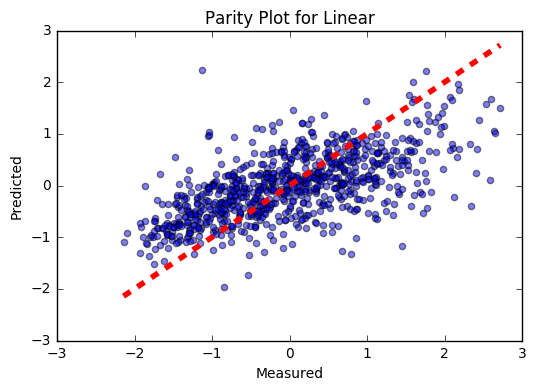

In [20]:
#parity plot for linear regression
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_linear, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()],'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Linear')
plt.show()

In [21]:
regr.score(x_training_set, y_training_set)

0.4441485486644498

In [22]:
#Lasso
regr_lasso=linear_model.Lasso(alpha=0.01)
regr_lasso.fit(x_training_set, y_training_set)
y_predict_lasso=regr_lasso.predict(x_test_set)

#evaluate

mse_lasso=mean_squared_error(y_test_set, y_predict_lasso)
rmse_lasso=sqrt(mse_lasso)
mae_lasso=mean_absolute_error(y_test_set, y_predict_lasso)
r2_lasso=r2_score(y_test_set, y_predict_lasso)
print('r2 for lasso:',r2_lasso)
print('rmse for lasso', rmse_lasso)
print('mae for lasso', mae_lasso)

r2 for lasso: 0.387530918181
rmse for lasso 0.7797645825572809
mae for lasso 0.621256794766


In [23]:
#evaluate the model on validation set

y_predict_lasso_ex=regr_lasso.predict(x_external_norm)
r2_lasso_ex=r2_score(y_external_norm, y_predict_lasso_ex)
mse_lasso_ex=mean_squared_error(y_external_norm, y_predict_lasso_ex)
rmse_lasso_ex=sqrt(mse_lasso_ex)
mae_lasso_ex=mean_absolute_error(y_external_norm, y_predict_lasso_ex)

print('r2_validation_set:', r2_lasso_ex)
print('rmse_validation_set:', rmse_lasso_ex)
print('mse_validation_set:', mse_lasso_ex)
print('mae_validation_set:', mae_lasso_ex)

r2_validation_set: 0.216207851914
rmse_validation_set: 0.7538940521381616
mse_validation_set: 0.568356241849
mae_validation_set: 0.592574523968


In [24]:
print(regr_lasso.coef_)

[ 0.0316829   0.0257131  -0.05365945  0.04085776  0.0235964  -0.05661666
 -0.02196304  0.14536947 -0.         -0.08186394  0.04220847  0.0073894
 -0.11623567  0.07552468 -0.04514268 -0.03701792  0.0111871   0.05811711
 -0.06870029  0.00901065 -0.06898892  0.05910666 -0.05452752 -0.
 -0.05574052 -0.01304799 -0.          0.05790856  0.05969025 -0.08253949]


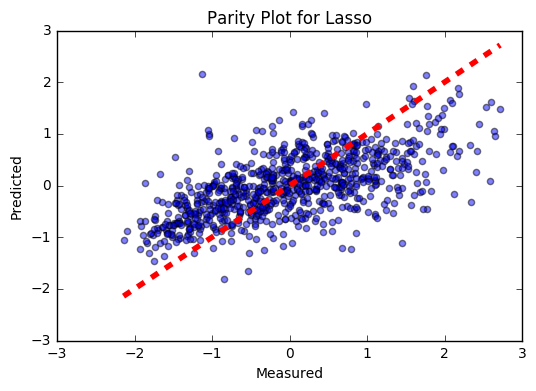

In [25]:
#parity plot for lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_lasso, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Lasso')
plt.show()

In [26]:
regr_lasso.score(x_training_set, y_training_set)

0.44282712535530822

In [27]:
#LassoCV
model_CV=LassoCV(cv=20).fit(x_training_set, y_training_set)
y_predict_CV = model_CV.predict(x_test_set)

#evaluate

mse_lassoCV=mean_squared_error(y_test_set, y_predict_CV)
rmse_lassoCV=sqrt(mse_lassoCV)
r2_lassoCV=r2_score(y_test_set, y_predict_CV)
mae_lassoCV=mean_absolute_error(y_test_set, y_predict_CV)

print('r2 for lassoCV:',r2_lassoCV)
print('rmse for lassoCV',rmse_lassoCV )
print('mae for lassoCV', mae_lassoCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for lassoCV: 0.387124437175
rmse for lassoCV 0.7800232951434117
mae for lassoCV 0.620806243259


In [28]:
print(model_CV.coef_)

[ 0.03173343  0.02585191 -0.05392606  0.04125647  0.02401614 -0.05726301
 -0.02275794  0.14622485 -0.         -0.08305089  0.04369888  0.00896113
 -0.11781677  0.07721402 -0.04716558 -0.03921185  0.01325321  0.06062231
 -0.07147484  0.01202461 -0.07185866  0.0620849  -0.05736905 -0.
 -0.05924474 -0.01643811 -0.          0.06186386  0.0642384  -0.08696323]


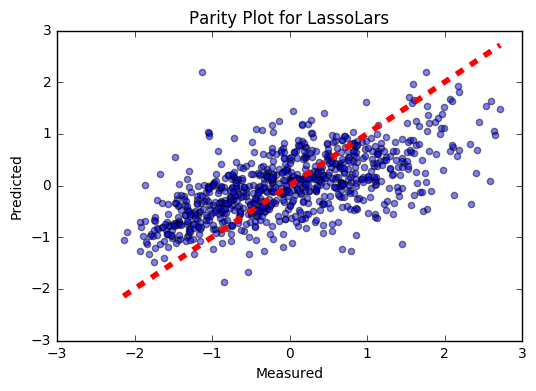

In [29]:
#parity plot for cross validated lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_CV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLars')
plt.show()

In [30]:
#LassoLarsCV
model_larsCV=LassoLarsCV(cv=20).fit(x_training_set, y_training_set)
y_predict_larsCV=model_larsCV.predict(x_test_set)

#evaluate
r2_larsCV=r2_score(y_test_set, y_predict_larsCV)
mse_larsCV=mean_squared_error(y_test_set, y_predict_larsCV)
rmse_larsCV=sqrt(mse_larsCV)
mae_larsCV=mean_absolute_error(y_test_set, y_predict_larsCV)
print('rmse for lassCV:', rmse_larsCV)
print('r2 for lasso larsCV:',r2_larsCV)
print('mae for larsCV:', mae_larsCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse for lassCV: 0.7800718339461803
r2 for lasso larsCV: 0.387048159525
mae for larsCV: 0.621380273981


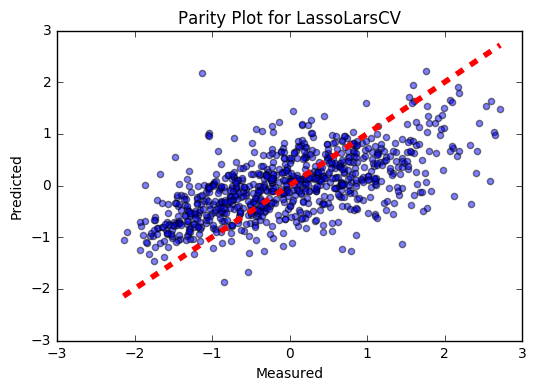

In [31]:
#parity plot for least angle regression lasso
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_larsCV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLarsCV')
plt.show()

In [32]:
#Bayesian Ridge
regr_b=linear_model.BayesianRidge()
model_b=regr_b.fit(x_training_set, y_training_set)
y_predict_b=model_b.predict(x_test_set)

#evaluate

mse_b=mean_squared_error(y_test_set, y_predict_b)
rmse_b=sqrt(mse_b)
mae_b=mean_absolute_error(y_test_set, y_predict_b)
r2_b=r2_score(y_test_set, y_predict_b)
print('r2 for bayesian in true space:',r2_b)
print('rmse for bayesian in true space:', rmse_b)
print('mae for bayesian in true space:', mae_b)

r2 for bayesian in true space: 0.386658361455
rmse for bayesian in true space: 0.7803198323601166
mae for bayesian in true space: 0.62050526531


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


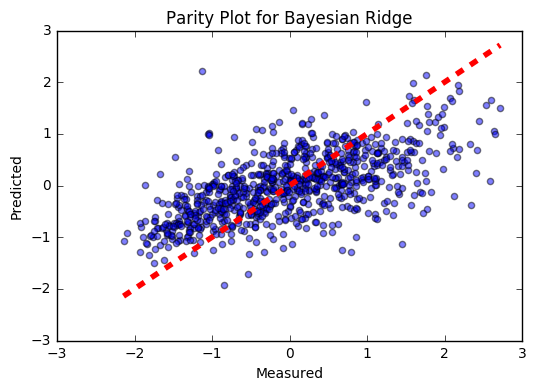

In [33]:
#parity plot for bayesian ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_b, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Bayesian Ridge')
plt.show()

In [34]:
#stochastic gradient descent
regr_sgd=SGDRegressor(loss='squared_loss', penalty=None, alpha=0.001, epsilon=0.0001)
model_sgd=regr_sgd.fit(x_training_set, y_training_set)
y_predict_sgd=model_sgd.predict(x_test_set)

#evaluate

mse_sgd=mean_squared_error(y_test_set, y_predict_sgd)
rmse_sgd=sqrt(mse_sgd)
mae_sgd=mean_absolute_error(y_test_set, y_predict_sgd)
r2_sgd=r2_score(y_test_set, y_predict_sgd)

print('r2 for sgd in true space:',r2_sgd)
print('rmse for sgd in true space:', rmse_sgd)
print('mae for sgd in true space:', mae_sgd)

r2 for sgd in true space: 0.355610157836
rmse for sgd in true space: 0.7998264523877161
mae for sgd in true space: 0.630102799144


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
#evaluate model on the external validation set
y_predict_sgd_ex=regr_sgd.predict(x_external_norm)
r2_sgd_ex=r2_score(y_external_norm, y_predict_sgd_ex)
mse_sgd_ex=mean_squared_error(y_external_norm, y_predict_sgd_ex)
rmse_sgd_ex=sqrt(mse_sgd_ex)
mae_sgd_ex=mean_absolute_error(y_external_norm, y_predict_sgd_ex)

print('r2_validation_set:', r2_sgd_ex)
print('rmse_validation_set:', rmse_sgd_ex)
print('mse_validation_set:', mse_sgd_ex)
print('mae_validation_set:', mae_sgd_ex)

r2_validation_set: -0.111243953133
rmse_validation_set: 0.8976655699525778
mse_validation_set: 0.805803475478
mae_validation_set: 0.711880566345


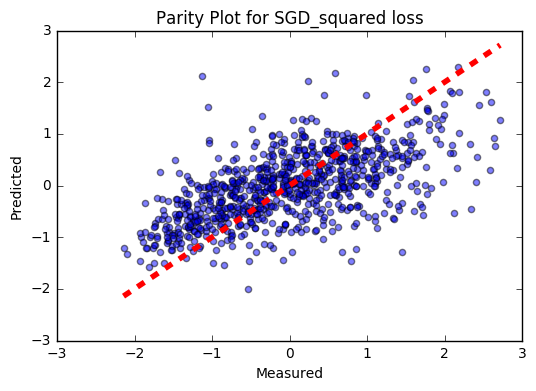

In [36]:
#parity plot for Stochastic Gradient Descent
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_squared loss')
plt.show()

In [37]:
regr_sgd2=linear_model.SGDRegressor(loss='huber', penalty=None)
model_sgd2=regr_sgd2.fit(x_training_set, y_training_set)
y_predict_sgd2=model_sgd2.predict(x_test_set)

#evaluate

mse_sgd2=mean_squared_error(y_test_set, y_predict_sgd2)
rmse_sgd2=sqrt(mse_sgd2)
mae_sgd2=mean_absolute_error(y_test_set, y_predict_sgd2)
r2_sgd2=r2_score(y_test_set, y_predict_sgd2)

print('r2 for sgd2 in true space:',r2_sgd2)
print('rmse for sgd2 in true space:', rmse_sgd2)
print('mae for sgd2 in true space:', mae_sgd2)

r2 for sgd2 in true space: 0.371850531225
rmse for sgd2 in true space: 0.7896832364461356
mae for sgd2 in true space: 0.616236091897


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#evaluate sgd on external validation set
y_predict_sgd2_ex=regr_sgd2.predict(x_external_norm)
r2_sgd2_ex=r2_score(y_external_norm, y_predict_sgd2_ex)
mse_sgd2_ex=mean_squared_error(y_external_norm, y_predict_sgd2_ex)
rmse_sgd2_ex=sqrt(mse_sgd2_ex)
mae_sgd2_ex=mean_absolute_error(y_external_norm, y_predict_sgd2_ex)

print('r2_validation_set:', r2_sgd2_ex)
print('rmse_validation_set:', rmse_sgd2_ex)
print('mse_validation_set:', mse_sgd2_ex)
print('mae_validation_set:', mae_sgd2_ex)

r2_validation_set: 0.272541938802
rmse_validation_set: 0.7262963190543982
mse_validation_set: 0.527506343072
mae_validation_set: 0.576178152139


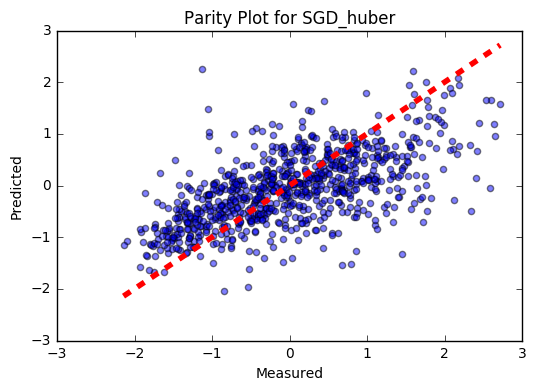

In [39]:
#parity plot for sgd_huber
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd2, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_huber')
plt.show()

In [40]:
regr_sgd3=linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none', alpha=0.0001)
model_sgd3=regr_sgd3.fit(x_training_set, y_training_set)
y_predict_sgd3=model_sgd3.predict(x_test_set)

#evaluate

mse_sgd3=mean_squared_error(y_test_set, y_predict_sgd3)
rmse_sgd3=sqrt(mse_sgd3)
mae_sgd3=mean_absolute_error(y_test_set, y_predict_sgd3)
r2_sgd3=r2_score(y_test_set, y_predict_sgd3)

print('r2 for sgd3 in true space:',r2_sgd3)
print('rmse for sgd3 in true space:', rmse_sgd3)
print('mae for sgd3 in true space:', mae_sgd3)

r2 for sgd3 in true space: 0.325287627094
rmse for sgd3 in true space: 0.8184285249604549
mae for sgd3 in true space: 0.63882871778


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


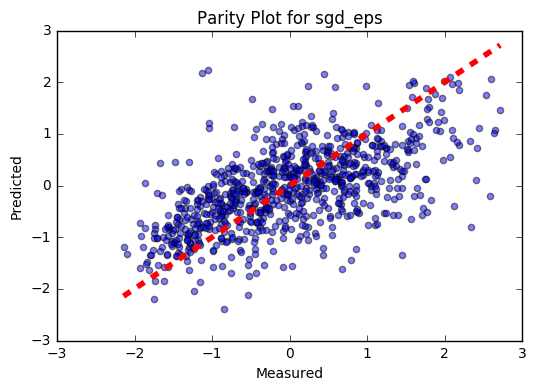

In [41]:
#parity plot for sgd_epsilon insensitive loss function
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd3, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for sgd_eps')
plt.show()

In [42]:
#using tree
regr_tree=tree.DecisionTreeRegressor()
model_tree=regr_tree.fit(x_training_set, y_training_set)
y_predict_tree=model_tree.predict(x_test_set)

#evaluate

mse_tree=mean_squared_error(y_test_set, y_predict_tree)
rmse_tree=sqrt(mse_tree)
mae_tree=mean_absolute_error(y_test_set, y_predict_tree)
r2_tree=r2_score(y_test_set, y_predict_tree)
print('r2 for tree in true space:',r2_tree)
print('rmse for tree in true space:', rmse_tree)
print('mae for tree in true space:', mae_tree)

r2 for tree in true space: -0.0752828343732
rmse for tree in true space: 1.0331961443945106
mae for tree in true space: 0.794634153478


In [43]:
#evaluating CART on external validation set
y_predict_tree_ex=regr_tree.predict(x_external_norm)
r2_tree_ex=r2_score(y_external_norm, y_predict_tree_ex)
mse_tree_ex=mean_squared_error(y_external_norm, y_predict_tree_ex)
rmse_tree_ex=sqrt(mse_tree_ex)
mae_tree_ex=mean_absolute_error(y_external_norm, y_predict_tree_ex)

print('r2_validation_set:', r2_tree_ex)
print('rmse_validation_set:', rmse_tree_ex)
print('mse_validation_set:', mse_tree_ex)
print('mae_validation_set:', mae_tree_ex)

r2_validation_set: -1.49566827863
rmse_validation_set: 1.3452509028121078
mse_validation_set: 1.80969999152
mae_validation_set: 1.05478059352


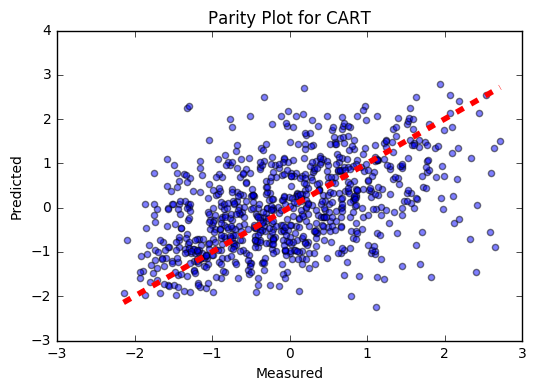

In [44]:
#parity plot for CART 
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_tree, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for CART')
plt.show()

In [45]:
#Ridge
regr_ridge=linear_model.Ridge(alpha=0.75)
model_ridge=regr_ridge.fit(x_training_set, y_training_set)
y_predict_ridge=model_ridge.predict(x_test_set)

#evaluate

mse_ridge=mean_squared_error(y_test_set, y_predict_ridge)
rmse_ridge=sqrt(mse_ridge)
mae_ridge=mean_absolute_error(y_test_set, y_predict_ridge)
r2_ridge=r2_score(y_test_set, y_predict_ridge)
print('r2 for ridge in true space:',r2_ridge)
print('rmse for ridge in true space:', rmse_ridge)
print('mae for ridge in true space:', mae_ridge)

r2 for ridge in true space: 0.386079969061
rmse for ridge in true space: 0.7806876736040693
mae for ridge in true space: 0.620337975192


In [46]:
#evaluate the model on external validation set
y_predict_ridge_ex=regr_ridge.predict(x_external_norm)
r2_ridge_ex=r2_score(y_external_norm, y_predict_ridge_ex)
mse_ridge_ex=mean_squared_error(y_external_norm, y_predict_ridge_ex)
rmse_ridge_ex=sqrt(mse_ridge_ex)
mae_ridge_ex=mean_absolute_error(y_external_norm, y_predict_ridge_ex)

print('r2_validation_set:', r2_ridge_ex)
print('rmse_validation_set:', rmse_ridge_ex)
print('mse_validation_set:', mse_ridge_ex)
print('mae_validation_set:', mae_ridge_ex)

r2_validation_set: 0.182317554358
rmse_validation_set: 0.7700203447343602
mse_validation_set: 0.592931331305
mae_validation_set: 0.600560717108


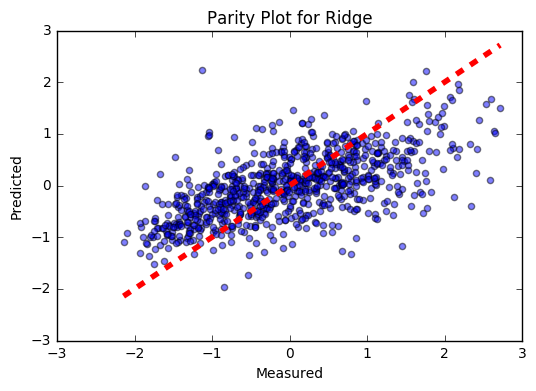

In [47]:
#parity plot for Ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_ridge, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Ridge')
plt.show()

In [48]:
#Kernel Ridge
regr_kr=KernelRidge(alpha=1.0)
model_kr=regr_kr.fit(x_training_set, y_training_set)
y_predict_kr=model_kr.predict(x_test_set)

#evaluate

mse_kr=mean_squared_error(y_test_set, y_predict_kr)
rmse_kr=sqrt(mse_kr)
mae_kr=mean_absolute_error(y_test_set, y_predict_kr)
r2_kr=r2_score(y_test_set, y_predict_kr)
print('r2 for kernel ridge in true space:',r2_kr)
print('rmse for kernel ridge in true space:', rmse_kr)
print('mae for kernel ridge in true space:', mae_kr)

r2 for kernel ridge in true space: 0.386082262349
rmse for kernel ridge in true space: 0.7806862154800729
mae for kernel ridge in true space: 0.620322819643


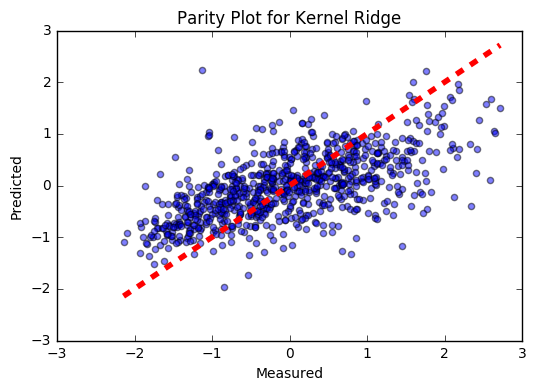

In [49]:
#parity plot for kernal ridge
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_kr, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Kernel Ridge')
plt.show()

In [50]:
#support vector machines
svr_rbf=SVR(kernel='rbf', C=1e3)
model_rbf=svr_rbf.fit(x_training_set, y_training_set)
y_predict_rbf=model_rbf.predict(x_test_set)

#evaluate

mse_rbf=mean_squared_error(y_test_set, y_predict_rbf)
rmse_rbf=sqrt(mse_rbf)
mae_rbf=mean_absolute_error(y_test_set, y_predict_rbf)
r2_rbf=r2_score(y_test_set, y_predict_rbf)
print('r2 for svm.rbf in true space:',r2_rbf)
print('rmse for svm.rbf in true space:', rmse_rbf)
print('mae for svm.rbf in true space:', mae_rbf)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.rbf in true space: 0.393317593429
rmse for svm.rbf in true space: 0.7760721895554216
mae for svm.rbf in true space: 0.596099926158


In [51]:
#evaluate the model on external validation set
y_predict_svr_rbf_ex=svr_rbf.predict(x_external_norm)
r2_svr_rbf_ex=r2_score(y_external_norm, y_predict_svr_rbf_ex)
mse_svr_rbf_ex=mean_squared_error(y_external_norm, y_predict_svr_rbf_ex)
rmse_svr_rbf_ex=sqrt(mse_svr_rbf_ex)
mae_svr_rbf_ex=mean_absolute_error(y_external_norm, y_predict_svr_rbf_ex)

print('r2_validation_set:', r2_svr_rbf_ex)
print('rmse_validation_set:', rmse_svr_rbf_ex)
print('mse_validation_set:', mse_svr_rbf_ex)
print('mae_validation_set:', mae_svr_rbf_ex)

r2_validation_set: -0.179602990333
rmse_validation_set: 0.9248638298810543
mse_validation_set: 0.855373103822
mae_validation_set: 0.754580887215


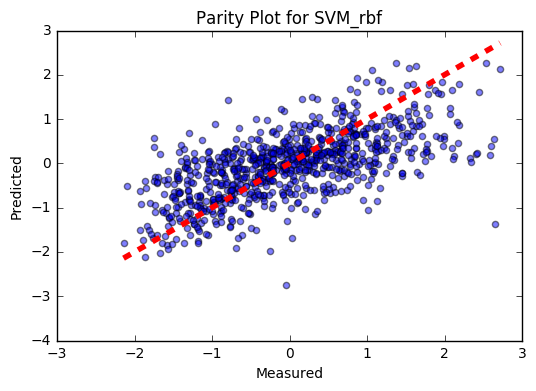

In [52]:
#parity plot for SVM_rbf
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_rbf, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_rbf')
plt.show()

In [53]:
svr_sig=SVR(kernel='sigmoid', C=1e3)
model_sig=svr_sig.fit(x_training_set, y_training_set)
y_predict_sig=model_sig.predict(x_test_set)

#evaluate

mse_sig=mean_squared_error(y_test_set, y_predict_sig)
rmse_sig=sqrt(mse_sig)
mae_sig=mean_absolute_error(y_test_set, y_predict_sig)
r2_sig=r2_score(y_test_set, y_predict_sig)

print('r2 for svm.sig in true space:',r2_sig)
print('rmse for svm.sig in true space:', rmse_sig)
print('mae for svm.sig in true space:', mae_sig)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.sig in true space: -53693296311.7
rmse for svm.sig in true space: 230877.41636165546
mae for svm.sig in true space: 189874.774506


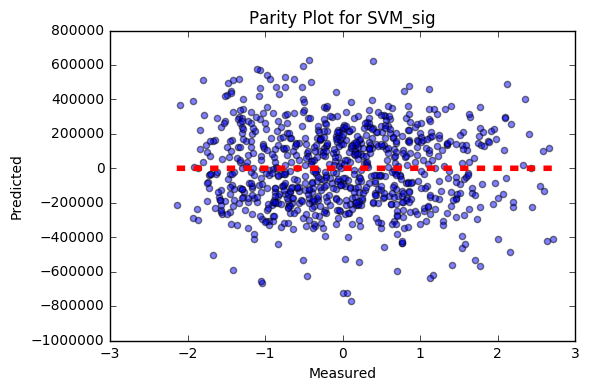

In [54]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sig, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_sig')
plt.show()

In [55]:
#C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf, rmse_rbf])
#C

In [56]:
C=np.array([r2_linear, r2_lasso, r2_lassoCV, r2_larsCV, r2_b, r2_sgd, r2_sgd2, r2_sgd3, r2_tree, r2_ridge, r2_kr, r2_rbf])
C

array([ 0.38607637,  0.38753092,  0.38712444,  0.38704816,  0.38665836,
        0.35561016,  0.37185053,  0.32528763, -0.07528283,  0.38607997,
        0.38608226,  0.39331759])

In [57]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

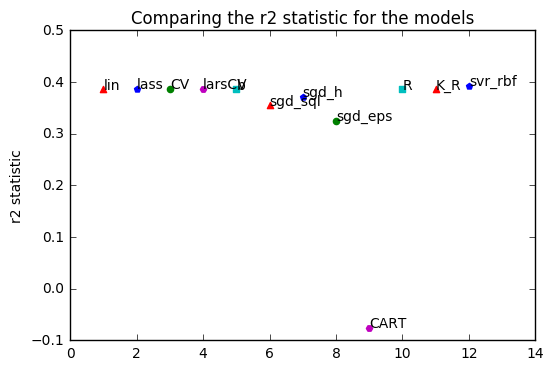

In [58]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.title('Comparing the r2 statistic for the models')
plt.show()

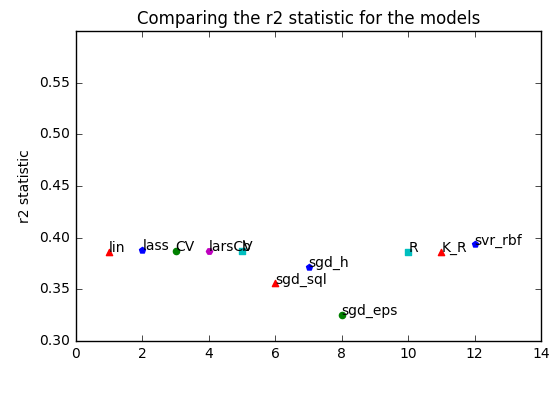

In [59]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.ylim([0.30, 0.6])
plt.title('Comparing the r2 statistic for the models')
plt.show()

In [60]:
C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf])
C

array([ 0.78068996,  0.77976458,  0.7800233 ,  0.78007183,  0.78031983,
        0.79982645,  0.78968324,  0.81842852,  1.03319614,  0.78068767,
        0.78068622,  0.77607219])

In [61]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

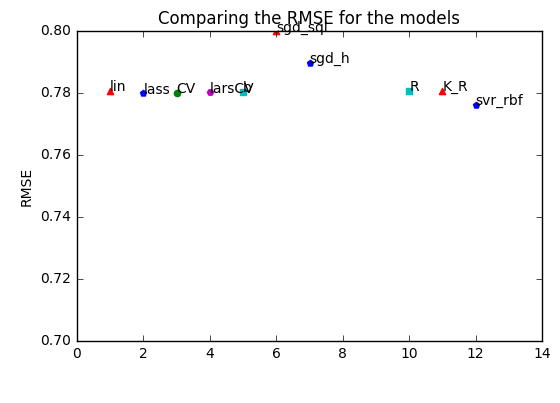

In [62]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('RMSE')
plt.ylim([0.70, 0.80])
plt.title('Comparing the RMSE for the models')
plt.show()

In [63]:
C=np.array([mae_linear, mae_lasso, mae_lassoCV, mae_larsCV, mae_b, mae_sgd, mae_sgd2, mae_sgd3, mae_tree, mae_ridge, mae_kr, mae_rbf])
C

array([ 0.62033729,  0.62125679,  0.62080624,  0.62138027,  0.62050527,
        0.6301028 ,  0.61623609,  0.63882872,  0.79463415,  0.62033798,
        0.62032282,  0.59609993])

In [64]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

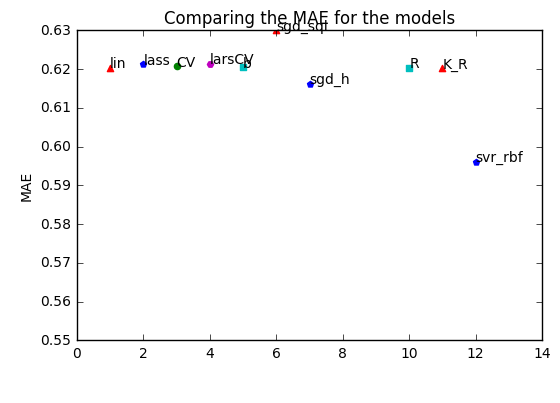

In [65]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('MAE')
plt.ylim([0.55, 0.63])
plt.title('Comparing the MAE for the models')
plt.show()

**NEURAL NETWORK**

In [66]:
#DIFFERENT TOPOLOGIES HAVE BEEN GIVEN TO 2D , 3D AND 2D/3D DESCRIPTORS AND ITERATIONS OF CONJUGATED GRADIENT DESCENT GIVEN
def baseline_model():
    model=Sequential()
    model.add(Dropout(0.2, input_shape=(30,)))
    model.add(Dense(30, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(24, init='normal', activation='relu'))
    model.add(Dense(12, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, init='normal'))
    # compile the model 
    epochs=100
    learning_rate=0.01
    momemtum=0.3
    decay=learning_rate/epochs
    sgd=SGD(lr=learning_rate, momentum=momemtum, decay=decay, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [67]:
seed=7
#fit and evaluate the NN
estimators=[]
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)))
pipeline=Pipeline(estimators)
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
results=cross_val_score(pipeline, x_training_set, y_training_set, cv=kfold, scoring='r2')
results.mean(), results.std()

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:

(0.23962075814767153, 0.20062783499403494)

In [68]:
results_test=cross_val_score(pipeline, x_test_set, y_test_set, cv=kfold, scoring='r2')
results_test.mean(), results_test.std()

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:

(0.24939948871284115, 0.14694486461923237)

**TENSORFLOW MODEL**

In [69]:
import tensorflow as tf

In [70]:
COLUMNS=list(x_df)
len(COLUMNS)

202